# IMPORTS

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import AllChem

# Scikit-learn for machine learning metrics and splitting
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
# PyTorch for neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import l1_loss
import torch.optim as optim
from torch.utils.data import DataLoader

# PyTorch Geometric for graph neural networks
import torch_geometric
from torch_geometric.nn import SchNet, NNConv, global_mean_pool, GCNConv
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as GeoDataLoader
# from torch_geometric.data import radius_graph

# PyTorch Cluster for clustering algorithms
from torch_cluster import radius_graph

# Matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import matplotlib

# Set Matplotlib settings
matplotlib.rcParams['font.family'] = 'Liberation Sans'
matplotlib.rcParams['font.size'] = 10

# CUDA availability and version
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
# print(torch.__version__)
# print(torch.version.cuda)

CUDA available: True
CUDA device name: Tesla T4


# LOAD DATA

In [4]:
####### Load expt and DFT data
excel = "computed_VBur"
bromides = "Sheet1"
short_bromides = "Sheet2"#"test"

bromide = pd.read_excel(excel+".xlsx",bromides,header=0, engine='openpyxl')
short = pd.read_excel(excel+".xlsx",short_bromides,header=0, engine='openpyxl')

bromide.insert(0, 'ID', 'bromide_' + bromide.index.astype(str))
short.insert(0, 'ID', 'bromide_' + short.index.astype(str))

# display(bromide)

clean_df = bromide[bromide["Steric"] > 40] 
clean_df = clean_df.reset_index(drop=True)

bromide_coppermap = pd.read_csv('bromide_coppermap.csv')
bromides_test = pd.merge(bromide_coppermap, clean_df, on='id_lucas', how='inner')
clean_df = clean_df[~clean_df['id_lucas'].isin(bromides_test['id_lucas'])]

# display(bromides_test)
display(clean_df)

,ID,id_lucas,id_therese,smiles,C_Steric_lucas,C_Steric_therese,Steric,LEC,min,max
0,bromide_0,alle_1,arbr2085,Brc1nc2ccccc2[nH]1,54.71778,54.732343,54.717780,53.296799,53.296799,53.296799
22,bromide_22,alle_28,arbr2114,Brc1ncccn1,55.62337,55.700242,55.623370,54.943161,54.943161,54.943161
23,bromide_23,alle_340,arbr4603,COc1ccc2nc(Br)sc2c1,57.84220,57.887626,57.842200,57.374557,57.355922,57.374557
26,bromide_26,alle_2001,NaN,FC(F)(F)c1ccc(OCc2ccccc2)cc1Br,67.52702,NaN,67.527020,67.146734,67.121692,67.155470
27,bromide_27,alle_2002,NaN,O=C1c2ccccc2-c2ccc(Br)c3cccc1c23,64.68156,NaN,64.681560,63.260576,63.260576,63.260576
...,...,...,...,...,...,...,...,...,...,...
5694,bromide_5695,NaN,arbr794,Brc1ccc(-c2cccc3ccccc23)cc1,NaN,60.837915,60.805468,58.477567,58.477567,58.477567
5695,bromide_5696,NaN,arbr795,Brc1ccc(-c2cccc3c2oc2ccccc23)cc1,NaN,60.630591,60.598725,58.440295,58.440295,58.440295
5696,bromide_5697,NaN,arbr798,Brc1ccc(-c2ccccn2)cc1,NaN,60.662039,60.630085,58.429230,58.422242,58.429230
5697,bromide_5698,NaN,arbr799,CC(C)(C)OC(=O)n1cccc1-c1ccc(Br)cc1,NaN,60.796566,60.764236,58.705856,58.674408,58.705856


# PREPARING DATASET

In [5]:
def mol_to_graph_data(mol):
    mol = mol
    # Node features: Atomic numbers, etc.
    atomic_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    is_in_ring = [1 if atom.IsInRing() else 0 for atom in mol.GetAtoms()]
    is_aromatic = [1 if atom.GetIsAromatic() else 0 for atom in mol.GetAtoms()]
    number_bonds = [atom.GetDegree() for atom in mol.GetAtoms()]

    # One-hot encoding for number of bonds
    max_bonds = 7  # Assuming a maximum of 6 bonds for any atom
    one_hot_bonds = [[1 if i == nb else 0 for i in range(max_bonds)] for nb in number_bonds]

    # Combine features
    features = [[atomic_num] + [is_ring] + [is_arom] + bond_vec 
                for atomic_num, is_ring, is_arom, bond_vec in zip(atomic_nums, is_in_ring, is_aromatic, one_hot_bonds)]
    x = torch.tensor(features, dtype=torch.float)

    # Get the adjacency matrix and convert it to edge index
    adj_matrix = Chem.GetAdjacencyMatrix(mol)
    edge_indices = np.nonzero(adj_matrix)
    edge_index = torch.tensor(np.array(edge_indices), dtype=torch.long)

    return x, edge_index

def graph_data(smiles, target):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    x, edge_index = mol_to_graph_data(mol)
    graph_data = Data(x=x, edge_index=edge_index, y=torch.tensor([target], dtype=torch.float))
    return graph_data

# Example usage
dataframe = clean_df  # Your DataFrame
target_column = "Steric"  # Column name for the target
graph_data_list = [graph_data(smiles, target) for smiles, target in zip(dataframe['smiles'], dataframe[target_column])]

[11:15:09] UFFTYPER: Unrecognized atom type: S_6+6 (1)


In [55]:
# # Save graph_data_list with torch.save
# torch.save(graph_data_list, 'graph_data_list_GCN.pt')
# # # Load graph_data_list with torch.load
# # graph_data_list = torch.load('graph_data_list_GCN.pt')

In [12]:
# display(graph_data_list)

# NN MODEL 

## EMBEDDING LAYER FOR ATOMS

In [6]:
class AtomEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(AtomEmbedding, self).__init__()
        # Embedding layers for atomic number, IsInRing, and IsAromatic
        self.atomic_num_embedding = nn.Embedding(100, embedding_dim // 2)
        self.is_in_ring_embedding = nn.Embedding(2, embedding_dim // 4)
        self.is_aromatic_embedding = nn.Embedding(2, embedding_dim // 4)
        
    def forward(self, features):
        # Convert features to long type for embedding
        features = features.long()  # Convert features to long type

        # Split features
        atomic_nums = features[..., 0]
        is_in_ring = features[..., 1]
        is_aromatic = features[..., 2]
        one_hot_bond = features[..., 3:]

        # Embed atomic number, IsInRing, and IsAromatic
        atomic_num_embedded = self.atomic_num_embedding(atomic_nums)
        is_in_ring_embedded = self.is_in_ring_embedding(is_in_ring)
        is_aromatic_embedded = self.is_aromatic_embedding(is_aromatic)

        # Concatenate embeddings and one-hot bond vector
        return torch.cat(
            [atomic_num_embedded, is_in_ring_embedded, is_aromatic_embedded, one_hot_bond], 
            dim=-1
        )

## MODEL ARCHITECTURE

In [7]:
class GCNModified(nn.Module):
    def __init__(self, embedding_dim, num_layers, num_filters):
        super(GCNModified, self).__init__()

        # Calculate the total embedding dimension
        total_embedding_dim = (embedding_dim // 2) + (embedding_dim // 4) + (embedding_dim // 4) + 7

        # Use AtomEmbedding layer
        self.atom_embedding = AtomEmbedding(embedding_dim)

        # GCN layers
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GCNConv(total_embedding_dim, num_filters))
        for _ in range(1, num_layers):
            self.gcn_layers.append(GCNConv(num_filters, num_filters))

        # Output layer
        self.lin = nn.Linear(num_filters, 1)

    def forward(self, x, edge_index, batch):
        # Embed atomic features
        x = self.atom_embedding(x)

        # Apply GCN layers
        for layer in self.gcn_layers:
            x = F.relu(layer(x, edge_index))

        # Global pooling
        x = global_mean_pool(x, batch)

        # Output layer
        x = self.lin(x)
        return x.squeeze(-1)

# TRAINING

## CROSS-VALIDATION

### TRAIN-TEST SPLIT

In [10]:
# # Set the random seed for reproducibility
# random_seed = 42
# np.random.seed(random_seed)
# torch.manual_seed(random_seed)

# # Your code for data collation and dataset splitting
# def collate_data_list(data_list):
#     return Batch.from_data_list(data_list)

# # Assuming you have a graph dataset called 'graph_data_list' and batch size of 32
# train_ratio = 0.8
# test_ratio = 0.2

# # Calculate the sizes for the training, validation, and test sets
# total_size = len(graph_data_list)
# train_size = int(train_ratio * total_size)
# test_size = total_size - train_size

# # Split the dataset into training, validation, and test sets
# train_dataset, test_dataset = torch.utils.data.random_split(
#     graph_data_list, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed)
# )

# # Create DataLoader for training, validation, and test sets
# batch_size = 32
# train_loader = GeoDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = GeoDataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Split the dataset into a training/validation set and a test set
training_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

batch_size = 32
# Initialize the test DataLoader
test_loader = GeoDataLoader(test_data, batch_size=batch_size, shuffle=False)

### HELPER

In [8]:
def evaluate_model_training(data_loader, model, device):
    model.eval()
    total_abs_error = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in data_loader:
            data.to(device)
            outputs = model(data.x, data.edge_index, data.batch)
            abs_error = l1_loss(outputs, data.y, reduction='sum')
            total_abs_error += abs_error.item()
            total_samples += data.y.size(0)

    return total_abs_error / total_samples

# # Evaluate the model on the training and validation sets
# mae_train = evaluate_model(training_loader, model, device)
# mae_val = evaluate_model(test_loader, model, device)

# print(f'MAE on Training Set: {mae_train:.2f}')
# print(f'MAE on Validation Set: {mae_val:.2f}')

In [9]:
def train_one_epoch(epoch_index, training_loader):

    running_loss = 0.
    last_loss = 0.
    batches_since_last_printout = 0.
    for i, data in enumerate(training_loader):
        data = data.to(device)
        optimizer.zero_grad()
            
        # Make predictions for this batch
        outputs = model(data.x, data.edge_index, data.batch)

        # Compute the loss and its gradients
        loss = loss_func(outputs, data.y)        
        loss.backward()

        # Adjust learning weights
        optimizer.step()
            
        # Gather data and report
        running_loss += loss.item()
        batches_since_last_printout += 1

        n_training_batches = len(training_loader)
        if i % 50 == 49 or i + 1 == n_training_batches:  # Check for every 50th batch or the last batch
            last_loss = running_loss / batches_since_last_printout  # Use the actual number of batches since the last printout
            running_loss = 0.
            batches_since_last_printout = 0  # Reset the counter

    return last_loss

In [10]:
def kfold_CV(i, total_combinations, training_data, n_folds, n_epochs, model, device, batch_size):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_mae_list = []
    val_mae_list = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(training_data)):
        print(f' *Fold {fold + 1}/{n_folds}')
        best_vmae = 1_000_000.
        best_tmae = 0

        # Split the data into training and validation sets
        train_dataset = [training_data[i] for i in train_indices]
        val_dataset = [training_data[i] for i in val_indices]

        # Create data loaders for training and validation sets
        training_loader = GeoDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        validation_loader = GeoDataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Train the model for the current fold
        for epoch in range(n_epochs):
            model.train(True)
            avg_loss = train_one_epoch(epoch, training_loader)

            # Evaluate the model on the training and validation sets
            mae_train = evaluate_model_CV(training_loader, model, device)
            mae_val = evaluate_model_CV(validation_loader, model, device)
            
            if epoch % 25 == 24:
                print(f'   EPOCH {epoch + 1}/{n_epochs}, Fold {fold + 1}/{n_folds}:, Combination {i}/{total_combinations}')
                print(f'   MAE train: {mae_train:.3f}; MAE validation {mae_val:.3f}')

            # Track best performance, and save the model's state
            if mae_val < best_vmae:
                best_vmae = mae_val
                best_tmae = mae_train

        print(f"  @Best MAE train: {best_tmae:.3f}, validation: {best_vmae:.3f}")

        # Save the best MAE for each fold
        train_mae_list.append(best_tmae)
        val_mae_list.append(best_vmae)

    # Calculate the average MAE across all folds
    avg_train_mae = np.mean(train_mae_list)
    avg_val_mae = np.mean(val_mae_list)

    return avg_train_mae, avg_val_mae

### CV

In [10]:
# # Define the filename for the output file
# output_filename_all = "hyperparameters_mae_2DGNN.txt"

# # # Write the header to the file
# # with open(output_filename_all, "w") as file:
# #     file.write("embedding_dim, num_rbf, cutoff, num_interactions, train_mae, test_mae\n")

# ########################################################
# embedding_dims = [128, 256] 
# num_layers = [20]
# total_combinations = len(embedding_dims) * len(num_layers)
# ########################################################
# for i, (embedding_dims, num_layers) in enumerate(itertools.product(embedding_dims, num_layers), start=1):
#     print('-' * 40)
#     print(f'Combination {i} of {total_combinations}: embedding_dim={embedding_dims}, num_interactions={num_layers}')
#     # Instantiate GCN model
#     num_filters = (embedding_dims // 2) + (embedding_dims // 4) + (embedding_dims // 4) + 7
#     model = GCNModified(embedding_dim, num_layers, num_filters)
#     optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
#     loss_func = torch.nn.L1Loss() #MAE
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)    
#     ##
#     n_epochs = 200
#     n_folds = 4
#     avg_train_mae, avg_val_mae = kfold_CV(i, total_combinations, training_data, n_folds, n_epochs, model, device, batch_size)
#     ##
#     with open(output_filename_all, "a") as file:
#         file.write(f"{embedding_dims}, {num_layers}, {avg_train_mae:.3f}, {avg_val_mae:.3f}\n")  

## FINAL TRAINING

In [11]:
########################################################
embedding_dims = 256 
num_layers = 5
########################################################
# Instantiate GCN model
num_filters = (embedding_dims // 2) + (embedding_dims // 4) + (embedding_dims // 4) + 7
model = GCNModified(embedding_dims, num_layers, num_filters)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_func = torch.nn.L1Loss() #MAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)    

GCNModified(
  (atom_embedding): AtomEmbedding(
    (atomic_num_embedding): Embedding(100, 128)
    (is_in_ring_embedding): Embedding(2, 64)
    (is_aromatic_embedding): Embedding(2, 64)
  )
  (gcn_layers): ModuleList(
    (0-4): 5 x GCNConv(263, 263)
  )
  (lin): Linear(in_features=263, out_features=1, bias=True)
)

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

def train_one_epoch_final(epoch_index, training_loader):
    running_loss = 0.
    last_loss = 0.
    batches_since_last_printout = 0.
    for i, data in enumerate(training_loader):
        data = data.to(device)
        optimizer.zero_grad()
            
        # Make predictions for this batch
        outputs = model(data.x, data.edge_index, data.batch)

        # Compute the loss and its gradients
        loss = loss_func(outputs, data.y)        
        loss.backward()

        # Adjust learning weights
        optimizer.step()
            
        # Gather data and report
        running_loss += loss.item()
        batches_since_last_printout += 1
        
        n_training_batches = len(training_loader)
        if i % 50 == 49 or i + 1 == n_training_batches:  # Check for every 50th batch or the last batch
            last_loss = running_loss / batches_since_last_printout  # Use the actual number of batches since the last printout
            running_loss = 0.
            batches_since_last_printout = 0  # Reset the counter

    # Update the learning rate based on the average loss of the epoch
    scheduler.step(last_loss)

    return last_loss

In [14]:
output_filename_training = "2DGNN_training_20_FINALTRAINING.txt"

# Write the header to the file
with open(output_filename_training, "w") as file:
    file.write("EPOCH, Adjusted MAE, MAE Train, MAE Test, Best MAE Test, epochs_since_improvement\n")

In [ ]:
########################################################
embedding_dims = 256
num_layers = 20
num_filters = (embedding_dims // 2) + (embedding_dims // 4) + (embedding_dims // 4) + 7
n_epochs = 2000
########################################################
early_stop_patience = 2000
# best_testmae = float('inf')
# epochs_since_improvement = 0
########################################################
# batch_size = 32
# Initialize the test DataLoader
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
training_loader = GeoDataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = GeoDataLoader(val_data, batch_size=batch_size, shuffle=False)
########################################################
model = GCNModified(embedding_dims, num_layers, num_filters)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_func = torch.nn.L1Loss() #MAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)    
########################################################
best_testmae = 1_000_000.
best_trainmae = 1_000_000.
best_adjusted_mae = 1_000_000.
epochs_since_improvement = 0
##
# overfit_penalty_factor = 0.75  # Adjust this factor to control the penalty strength
overfit_penalty_factor = 0.3  # Adjust this value as needed
relative_difference_threshold = 0.2  # Define a threshold for acceptable relative difference

for epoch in range(n_epochs):
    model.train(True)
    avg_loss = train_one_epoch_final(epoch, training_loader)

    # Evaluate the model on the training and validation sets
    mae_train = evaluate_model_training(training_loader, model, device)
    mae_test = evaluate_model_training(val_loader, model, device)
    
    overfit_penalty_factor = 0.3  # Adjust this value as needed
    relative_difference_threshold = 0.2  # Define a threshold for acceptable relative difference

    # Calculate the relative difference between test and train MAE
    relative_difference = (mae_test - mae_train) / mae_train

    # Apply a penalty if the relative difference exceeds the threshold
    if relative_difference > relative_difference_threshold:
        overfit_penalty = (relative_difference - relative_difference_threshold) * overfit_penalty_factor
    else:
        overfit_penalty = 0

    adjusted_mae = mae_train + overfit_penalty
    
    # Track best performance, and save the model's state
    if adjusted_mae < best_adjusted_mae:
        best_adjusted_mae = adjusted_mae
        best_testmae = mae_test
        best_trainmae = mae_train
        torch.save(model.state_dict(), 'best_model_2DGNN_20_FINALTRAINING.pth')  # Save the model state
        epochs_since_improvement = 0 
    else:
        epochs_since_improvement += 1

    if epoch % 2 == 1:
        print(f'   EPOCH {epoch + 1}/{n_epochs}')
        print(f'   Adjusted MAE: {adjusted_mae:.3f}; MAE train: {mae_train:.3f}; MAE test: {mae_test:.3f}; Epochs Since Improvement: {epochs_since_improvement}')

    if epochs_since_improvement >= early_stop_patience:
        print(f"No improvement in MAE for {early_stop_patience} epochs. Stopping training.")
        break
        
    with open(output_filename_training, "a") as file:
        file.write(f"EPOCH: {epoch}; Adjusted MAE: {adjusted_mae:.3f}; MAE Train: {mae_train:.3f}; MAE Test: {mae_test:.3f}; Best MAE Test: {best_testmae:.3f}; epochs_since_improvement: {epochs_since_improvement}\n")      

print(f"@Best MAE train: {best_testmae:.3f}")        

   EPOCH 2/2000
   Adjusted MAE: 10.595; MAE train: 10.595; MAE test: 10.793; Epochs Since Improvement: 1
   EPOCH 4/2000
   Adjusted MAE: 2.285; MAE train: 2.285; MAE test: 2.294; Epochs Since Improvement: 0
   EPOCH 6/2000
   Adjusted MAE: 2.414; MAE train: 2.414; MAE test: 2.488; Epochs Since Improvement: 2
   EPOCH 8/2000
   Adjusted MAE: 14.404; MAE train: 14.404; MAE test: 14.259; Epochs Since Improvement: 4
   EPOCH 10/2000
   Adjusted MAE: 2.811; MAE train: 2.811; MAE test: 2.727; Epochs Since Improvement: 1
   EPOCH 12/2000
   Adjusted MAE: 3.443; MAE train: 3.443; MAE test: 3.545; Epochs Since Improvement: 3
   EPOCH 14/2000
   Adjusted MAE: 3.473; MAE train: 3.473; MAE test: 3.381; Epochs Since Improvement: 1
   EPOCH 16/2000
   Adjusted MAE: 1.707; MAE train: 1.707; MAE test: 1.705; Epochs Since Improvement: 0
   EPOCH 18/2000
   Adjusted MAE: 5.141; MAE train: 5.141; MAE test: 5.250; Epochs Since Improvement: 1
   EPOCH 20/2000
   Adjusted MAE: 1.256; MAE train: 1.256; MAE

Epoch 00156: reducing learning rate of group 0 to 1.0000e-07.
   EPOCH 156/2000
   Adjusted MAE: 0.586; MAE train: 0.586; MAE test: 0.653; Epochs Since Improvement: 14
   EPOCH 158/2000
   Adjusted MAE: 0.976; MAE train: 0.976; MAE test: 1.054; Epochs Since Improvement: 16
   EPOCH 160/2000
   Adjusted MAE: 0.956; MAE train: 0.956; MAE test: 1.032; Epochs Since Improvement: 18
   EPOCH 162/2000
   Adjusted MAE: 0.615; MAE train: 0.615; MAE test: 0.696; Epochs Since Improvement: 20
   EPOCH 164/2000
   Adjusted MAE: 1.044; MAE train: 1.044; MAE test: 1.066; Epochs Since Improvement: 1
   EPOCH 166/2000
   Adjusted MAE: 0.471; MAE train: 0.456; MAE test: 0.570; Epochs Since Improvement: 3
   EPOCH 168/2000
   Adjusted MAE: 0.767; MAE train: 0.767; MAE test: 0.813; Epochs Since Improvement: 5
   EPOCH 170/2000
   Adjusted MAE: 0.648; MAE train: 0.648; MAE test: 0.705; Epochs Since Improvement: 7
   EPOCH 172/2000
   Adjusted MAE: 1.162; MAE train: 1.162; MAE test: 1.195; Epochs Since Impr

   EPOCH 310/2000
   Adjusted MAE: 0.371; MAE train: 0.295; MAE test: 0.429; Epochs Since Improvement: 18
   EPOCH 312/2000
   Adjusted MAE: 0.807; MAE train: 0.807; MAE test: 0.883; Epochs Since Improvement: 20
   EPOCH 314/2000
   Adjusted MAE: 0.359; MAE train: 0.306; MAE test: 0.421; Epochs Since Improvement: 22
   EPOCH 316/2000
   Adjusted MAE: 0.741; MAE train: 0.741; MAE test: 0.822; Epochs Since Improvement: 24
   EPOCH 318/2000
   Adjusted MAE: 0.401; MAE train: 0.337; MAE test: 0.476; Epochs Since Improvement: 26
   EPOCH 320/2000
   Adjusted MAE: 0.377; MAE train: 0.301; MAE test: 0.437; Epochs Since Improvement: 28
   EPOCH 322/2000
   Adjusted MAE: 0.409; MAE train: 0.348; MAE test: 0.488; Epochs Since Improvement: 30
   EPOCH 324/2000
   Adjusted MAE: 0.656; MAE train: 0.656; MAE test: 0.744; Epochs Since Improvement: 32
   EPOCH 326/2000
   Adjusted MAE: 0.756; MAE train: 0.756; MAE test: 0.854; Epochs Since Improvement: 34
   EPOCH 328/2000
   Adjusted MAE: 0.370; MAE 

# METRICS

In [12]:
from sklearn.metrics import r2_score
from collections import defaultdict

def evaluate_model(data_loader, model, device):
    model.eval()
    total_abs_error = 0.0
    predictions = []
    mol_ids = []
    true_values = []
    
    with torch.no_grad():
        for data in data_loader:
            data.to(device)
            outputs = model(data.x, data.edge_index, data.batch)
            abs_error = l1_loss(outputs, data.y, reduction='sum')
            total_abs_error += abs_error.item()
            
            predictions.extend(outputs.cpu().numpy())
            true_values.extend(data.y.cpu().numpy())
            
    r2 = r2_score(true_values, predictions)
    
    return total_abs_error / len(true_values), r2

# # Evaluate the model on the training and validation sets
# mae_train, r2_train = evaluate_model(training_loader, model, device)
# mae_test, r2_test = evaluate_model(test_loader, model, device)

# print(f'MAE on Training Set: {mae_train:.2f}')
# print(f'R2 Training Set: {r2_train:.2f}')
# print(f'MAE on Validation Set: {mae_test:.2f}')

In [15]:
########################################################
embedding_dims = 256
num_layers = 20
num_filters = (embedding_dims // 2) + (embedding_dims // 4) + (embedding_dims // 4) + 7
#####

# Initialize the model with the same architecture as the saved model
model = GCNModified(embedding_dims, num_layers, num_filters)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)    
training_loader = GeoDataLoader(training_data, batch_size=batch_size, shuffle=True)

# Load the saved state dictionary
model.load_state_dict(torch.load('best_model_2DGNN_20.pth'))
# torch.save(model.state_dict(), 'best_model_256_20_2DGNN.pth')

# Set the model to evaluation mode
model.eval()

# Evaluate the model on the training and validation sets
mae_train, r2_train = evaluate_model(training_loader, model, device)
mae_test, r2_test = evaluate_model(test_loader, model, device)

print(f'MAE on Training Set: {mae_train:.3f}')
print(f'R2 Training Set: {r2_train:.2f}')
print(f'MAE on Validation Set: {mae_test:.3f}')
print(f'R2 Validation Set: {r2_test:.2f}')

# MAE on Training Set: 0.33
# R2 Training Set: 0.96
# MAE on Validation Set: 0.45
# R2 Validation Set: 0.93

MAE on Training Set: 0.354
R2 Training Set: 0.95
MAE on Validation Set: 0.451
R2 Validation Set: 0.92


In [16]:
def make_predictions(data_loader, model, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            outputs = model(data.x, data.edge_index, data.batch)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(data.y.cpu().numpy())
    
    return actuals, predictions

train_actuals, train_predictions = make_predictions(training_loader, model, device)
test_actuals, test_predictions = make_predictions(test_loader, model, device)

MAE on Training Set: 0.354
R2 Training Set: 0.95
MAE on Validation Set: 0.451
R2 Validation Set: 0.92


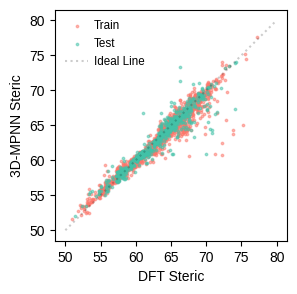

In [17]:
# Assuming min_y and max_y are set to the desired range
min_y = 50
max_y = 80

# Generate the ticks for both x and y axes
ticks = np.arange(min_y, max_y + 1, 5)

# Plot the predicted vs. actual values
print(f'MAE on Training Set: {mae_train:.3f}')
print(f'R2 Training Set: {r2_train:.2f}')
print(f'MAE on Validation Set: {mae_test:.3f}')
print(f'R2 Validation Set: {r2_test:.2f}')

plt.figure(figsize=(3, 3))

plt.scatter(train_actuals, train_predictions, marker='o', s=3, color='#FC766AFF', label='Train', alpha=0.5)
plt.scatter(test_actuals, test_predictions, marker='o', s=3, color='#42C2A8', label='Test', alpha=0.5)
plt.plot([min_y, max_y], [min_y, max_y], color='black', alpha=0.2, linestyle=':', label='Ideal Line')

plt.xlabel("DFT Steric")
plt.ylabel("3D-MPNN Steric")
plt.yticks(ticks)
plt.xticks(ticks)

plt.legend(fontsize='small', frameon=False, handletextpad=0.5)
# plt.legend(loc='upper left', fontsize='small', frameon=False, handletextpad=0.5)
# plt.savefig('MPNN_128x128_200.png', dpi=600, bbox_inches='tight')
plt.show()

# END